In [0]:
!pip install tensorforce

     |████████████████████████████████| 348kB 3.4MB/s 


In [0]:
#connect to Google Colab TPUs
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0
Running on TPU  ['10.1.220.218:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.1.220.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.1.220.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
import tensorforce
from tensorforce.environments import Environment
from tensorforce.agents import Agent
from tensorforce.execution import Runner
from tensorforce.core.networks import LayeredNetwork

import os
import gym
from gym import wrappers
import numpy as np
import matplotlib.pyplot as plt


In [0]:
# Modify/Set Hyperparameters for NN's 
class hasselt_hyp:
  '''
  Hyperparameters according to DDQN paper from Hasselt et al 2015
  '''
  def __init__(self):
    #self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00025,
                                                # momentum=0.95)
    self.learning_rate=0.00025
    self.momentum=0.95
    self.num_iterations = 20000
    self.target_update_period = 10000
    self.gamma = 0.99
    self.replay_buffer_max_length = 1000000
    self.collect_steps_per_iteration = 4 
    self.batch_size = 32
    self.log_interval = 20000
    self.num_eval_episodes = 50
    self.eval_interval = 1000000
    self.size_of_replay_memory=30000
    #calvin - I'm adding these hyperparams?
    self.epsilon = 0.1
    self.epsilon_decay_period=1000000

In [0]:
#apply wrappers
print(tensorforce.__version__)
hasselt = hasselt_hyp()

def create_env(game='Alien-v0'):
  print('Creating env for {}'.format(game))
  env = gym.make(game)
  env = wrappers.atari_preprocessing.AtariPreprocessing(env,frame_skip=1)
  env = wrappers.frame_stack.FrameStack(env,4)
  env = Environment.create(environment=env)
  return env

env = create_env(game = 'Atlantis-v0')

0.5.4
Creating env for Atlantis-v0


In [0]:
#create network
'''The convolution network used in the experiment is exactly the one
proposed by proposed by Mnih et al. (2015), we only provide de-
tails here for completeness. The input to the network is a 84x84x4
tensor containing a rescaled, and gray-scale, version of the last four
frames. The first convolution layer convolves the input with 32 fil-
ters of size 8 (stride 4), the second layer has 64 layers of size 4
(stride 2), the final convolution layer has 64 filters of size 3 (stride
1). This is followed by a fully-connected hidden layer of 512 units.
All these layers are separated by Rectifier Linear Units (ReLu). Fi-
nally, a fully-connected linear layer projects to the output of the
network, i.e., the Q-values. The optimization employed to train the
network is RMSProp (with momentum parameter 0.95).'''

def create_network():
  layers = [dict(type='conv2d',size=32,window=8,stride=4),#(8x8x32) with stride 4
            dict(type='conv2d',size=64,window=4,stride=2),#(4x4x64) with stride 2
            dict(type='conv2d',size=64,window=3,stride=1),#(3x3x64) with stride 1
            dict(type='flatten'),
            dict(type='dense',size=512,activation='relu'),
            ]
  return layers

In [0]:
exploration=dict(
    type='decaying', unit='timesteps', decay='polynomial',
    initial_value=1.0, decay_steps=40000, final_value=0.1
)
agent = Agent.create(agent='dqn',
                     environment=env,
                     memory=hasselt.size_of_replay_memory,
                     max_episode_timesteps=3000,
                     learning_rate=hasselt.learning_rate,
                     discount=hasselt.gamma,
                     exploration=exploration,
                     target_sync_frequency=10000,
                     network=dict(type='layered', layers=create_network()),
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [0]:
# Train
def train_and_eval_agent(agent, env, num_episodes=100,eval_every=10):
  agent.reset()
  query = ['action-distribution-probabilities']
  max_q_probs = []
  training_rewards = []
  eval_rewards = []
  timesteps = 0
  for episode in range(num_episodes):
      states = env.reset()
      terminal = False
      highscore=0.0
      cumulative=0.0
      while not terminal:
          actions, queried = agent.act(states=states,query=query)
          max_q_probs.append(np.max(queried))
          states, terminal, reward = env.execute(actions=actions)
          agent.observe(terminal=terminal, reward=reward)
          timesteps+=1
          cumulative+=reward
      print('Episode {}: Cumulative Reward: {} Timesteps: {}'.format(episode,cumulative,timesteps))  
      training_rewards.append(cumulative)

      if episode%eval_every==0:
          print('Evaluating...')
          highscore, avg_score = evaluate_agent(agent,env,highscore,num_episodes=5)
          eval_rewards.append(avg_score)
      else:
          eval_rewards.append(None)

  return max_q_probs, training_rewards, eval_rewards

# Evaluate
def evaluate_agent(agent, env, highscore, num_episodes=5):
  sum_rewards = 0.0

  for _ in range(num_episodes):
      states = env.reset()
      internals = agent.initial_internals()
      terminal = False
      while not terminal:
          actions, internals = agent.act(states=states, internals=internals, evaluation=True)
          states, terminal, reward = env.execute(actions=actions)
          sum_rewards += reward

  avg_score = sum_rewards / num_episodes
  print('Mean episode reward: {}'.format(avg_score) )
  if avg_score>highscore:
            agent.save(directory='best_agents',
                       filename='dqn-Alien-v0_best_eval.hdf5',
                       format='hdf5')
  return highscore, avg_score


In [0]:
%timeit
try:
  os.mkdir('best_agents')
except:
  pass

max_q_probs, training_rewards, eval_rewards = train_and_eval_agent(agent,env)

Episode 0: Cumulative Reward: 18600.0 Timesteps: 2046
Evaluating...
Mean episode reward: 3020.0
Episode 1: Cumulative Reward: 12300.0 Timesteps: 3593
Episode 2: Cumulative Reward: 6900.0 Timesteps: 4523
Episode 3: Cumulative Reward: 20600.0 Timesteps: 6531
Episode 4: Cumulative Reward: 12400.0 Timesteps: 8054
Episode 5: Cumulative Reward: 22000.0 Timesteps: 10242
Episode 6: Cumulative Reward: 15500.0 Timesteps: 11671
Episode 7: Cumulative Reward: 17900.0 Timesteps: 13244
Episode 8: Cumulative Reward: 30000.0 Timesteps: 15125
Episode 9: Cumulative Reward: 16600.0 Timesteps: 17161
Episode 10: Cumulative Reward: 22800.0 Timesteps: 19209
Evaluating...
Mean episode reward: 4180.0
Episode 11: Cumulative Reward: 20600.0 Timesteps: 21075
Episode 12: Cumulative Reward: 18900.0 Timesteps: 22668
Episode 13: Cumulative Reward: 13000.0 Timesteps: 23931
Episode 14: Cumulative Reward: 28700.0 Timesteps: 25964
Episode 15: Cumulative Reward: 18300.0 Timesteps: 28169
Episode 16: Cumulative Reward: 15600

In [0]:
%matplotlib inline

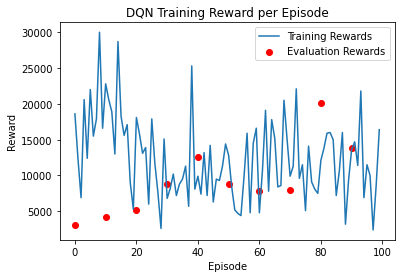

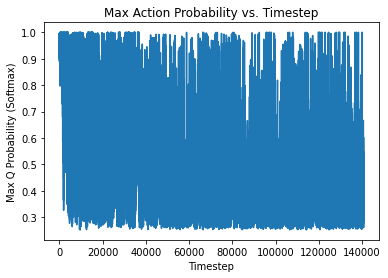

In [0]:
fig1,ax1 = plt.subplots(1,1)
ax1.plot(training_rewards)
ax1.scatter(np.arange(100),eval_rewards,c='r')
ax1.set_title('DQN Training Reward per Episode')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.legend(['Training Rewards', 'Evaluation Rewards'],loc='upper right')
fig2,ax2 = plt.subplots(1,1)
ax2.plot(max_q_probs)
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Max Q Probability (Softmax)')
ax2.set_title('Max Action Probability vs. Timestep')
plt.show()

In [0]:
runner = Runner(agent=agent,environment=env)
runner.run(num_episodes=10,evaluation=False)


Episodes: 100%|██████████| 10/10 [02:56, reward=380.00, ts/ep=791, sec/ep=15.57, ms/ts=19.7, agent=91.5%]

Episodes: 100%|██████████| 10/10 [02:35, reward=510.00, ts/ep=994, sec/ep=19.31, ms/ts=19.4, agent=91.5%]

In [0]:
# Close agent and environment
agent.close()
env.close()